installing and importing packages - this way it should work both with colab and jupyter notebook in anaconda

In [77]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy 
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install osmnx 
!{sys.executable} -m pip install pingouin 
!{sys.executable} -m pip install owslib 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import geopandas as gpd
import osmnx as ox
import urllib
import pingouin
import owslib
from owslib.wms import WebMapService




## these are for geopandas.explore() method and for some reason it works locally but not in colab, so I comment it out
#!{sys.executable} -m pip install folium 
#!{sys.executable} -m pip install mapclassify 
#!{sys.executable} -m pip install openpyxl 

#import folium
#import mapclassify
#import openpyxl

#!{sys.executable} -m pip install plotly
#import plotly.graph_objs as go

     -------------------------------------- 221.1/221.1 kB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 3.8/3.8 MB 22.0 MB/s eta 0:00:00
     -------------------------------------- 151.7/151.7 kB 8.8 MB/s eta 0:00:00


Getting the traffic accident data

*It's not that I am trying to sneak car accidents in the weater, it's just some data I had on hand:)*

In [3]:
def get_accidents_gdf(url):
  #had to add encoding to parse German symbols properly
  df = pd.read_csv(url,header = 0, sep = ';',decimal=',', encoding='ISO-8859-1') 
  gdf_accidents = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.XGCSWGS84, df.YGCSWGS84),crs=4326)
  #we do not need coordinates separately, we have them in 'geometry' now
  gdf_accidents.drop(columns=['LINREFX','LINREFY','XGCSWGS84','YGCSWGS84'],inplace=True) 
  return gdf_accidents

#not sure if links are permanent, see https://daten.berlin.de/search/node/Stra%C3%9Fenverkehrsunf%C3%A4lle%20nach%20Unfallort
gdf_accidents_21 = get_accidents_gdf('https://download.statistik-berlin-brandenburg.de/c2b6d25afa19b607/8d9164595b8b/AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_2021_Datensatz.csv')
gdf_accidents_20 = get_accidents_gdf('https://download.statistik-berlin-brandenburg.de/8a7423663f039221/892d24383b99/AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_2020_Datensatz.csv')
gdf_accidents_19 = get_accidents_gdf('https://download.statistik-berlin-brandenburg.de/8b666106e2a7b528/7c0c3db5ab9c/AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_2019_Datensatz.csv')
gdf_accidents_18 = get_accidents_gdf('https://download.statistik-berlin-brandenburg.de/102d8fde949519f6/d99e618a1ec6/AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_2018_Datensatz.csv')

In the next cells I check the 2019 dataset, as somtheing seem to be wrong...
Note that to show the next cell output, the notebook file should be added to trusted

In [4]:
## I could not make it work in Colab, so I comment it out for now
## if you want to run in locally, do not forget to uncomment imports above

#gdf_accidents_19.explore()

In [5]:
#Indeed, one data point has wrong coordinate, it messes up plotting
print(gdf_accidents_19.head())
print(gdf_accidents_19[gdf_accidents_19.OBJECTID==201196])

   OBJECTID  LAND  BEZ       LOR          STRASSE  UJAHR  UMONAT  USTUNDE  \
0     49090    11   12  12301203     Wittenau Süd   2019       1       13   
1     49091    11    3   3040818       Pankow Süd   2019       1        9   
2     49093    11   12  12103115  Breitkopfbecken   2019       3       21   
3     49096    11    6   6040703       Nikolassee   2019       1        7   
4     49097    11    7   7030303     Grazer Platz   2019       2       15   

   UWOCHENTAG  UKATEGORIE  ...  UTYP1  ULICHTVERH  IstRad  IstPKW  IstFuss  \
0           6           3  ...      3           0       1       1        0   
1           5           3  ...      3           0       1       1        0   
2           6           3  ...      1           2       1       0        0   
3           6           2  ...      4           1       0       1        1   
4           3           3  ...      6           0       0       1        0   

   IstKrad  IstGkfz  IstSonstige  USTRZUSTAND                   geom

I've checked the CSV file and it contains an error for that data entry, part of the record is shifted one column to the right, so I have to manually correct it:

In [6]:

gdf_accidents_19.loc[gdf_accidents_19.index==11893,'IstSonstige'] = np.nan
gdf_accidents_19.loc[gdf_accidents_19.index==11893,'USTRZUSTAND'] = np.nan
#but it is clear how to fix the coordinates
new_point = gpd.points_from_xy([13.60354728], [52.54675821])[0]
gdf_accidents_19.loc[gdf_accidents_19.index==11893,'geometry'] = new_point

                                            geometry  bbox_north  bbox_south  \
0  MULTIPOLYGON (((13.08835 52.41963, 13.09021 52...   52.675509   52.338245   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0  13.761161  13.088345  307789109  relation   62422  52.517037  13.38886   

      display_name     class            type  importance  
0  Berlin, Germany  boundary  administrative    1.007539  


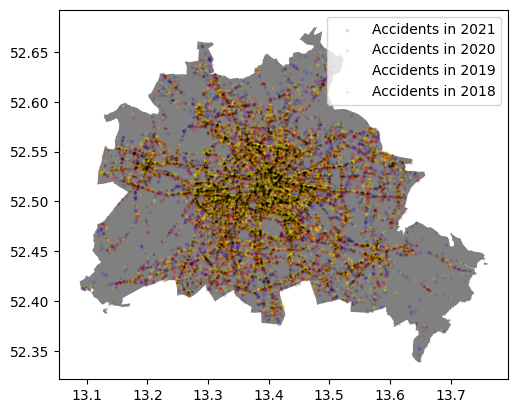

In [7]:
#rather meaningless plot, also I cannot produce legend without dirty hacks - would be better to have all the data in one df?
city = ox.geocode_to_gdf('Berlin, Germany')
print(city.head())
ax = ox.project_gdf(city).to_crs("EPSG:4326").plot(fc='gray')

labels = ['Accidents in 2021', 'Accidents in 2020', 'Accidents in 2019', 'Accidents in 2018']
gdf_accidents_21.plot(ax=ax, markersize=3, color='blue', marker='o', alpha=0.1, label=labels[0])
gdf_accidents_20.plot(ax=ax, markersize=3, color='red', marker='^', alpha=0.1, label=labels[1])
gdf_accidents_19.plot(ax=ax, markersize=3, color='yellow', marker='v', alpha=0.1, label=labels[2])
gdf_accidents_18.plot(ax=ax, markersize=3, color='black', marker='.', alpha=0.1, label=labels[3])
ax.legend()

Import geometry of voting districts

In [8]:
url='https://download.statistik-berlin-brandenburg.de/db8c83613aceb93e/14a42eb32a76/RBS_OD_UWB_AH21.zip'
filename = 'RBS_OD_UWB_AH21.zip'
urllib.request.urlretrieve(url, filename)
file = "RBS_OD_UWB_AH21.zip!RBS_OD_UWB_AH21.shp"
vote_geom = gpd.read_file(file).to_crs("EPSG:4326")
#drop unnececary data
vote_geom.drop(columns=['UWB3','BWB3','AWK','BEZ','BWK'],inplace=True) 

print(vote_geom.head())
#print(vote_geom.dtypes)
#print(vote_geom.info)

     UWB   BWB                                           geometry
0  01100  011A  POLYGON ((13.37094 52.52692, 13.36956 52.52890...
1  01101  011B  POLYGON ((13.36896 52.53377, 13.36673 52.53577...
2  01102  011B  POLYGON ((13.36896 52.53377, 13.36904 52.53381...
3  01103  011C  POLYGON ((13.38218 52.53126, 13.38217 52.53127...
4  01104  011D  POLYGON ((13.38798 52.52936, 13.38535 52.52871...


Now plot number of accidents per vorting district in 21:

Text(0.5, 1.0, 'Accidents per voting district in 2021')

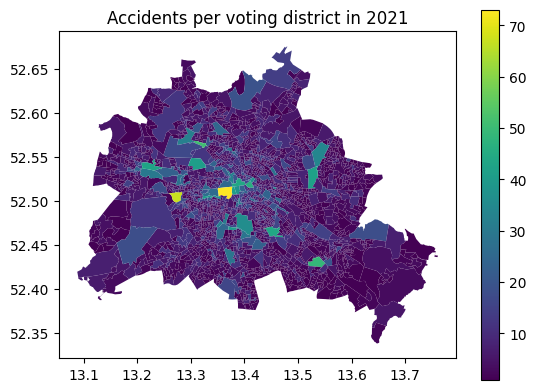

In [9]:
def count_points_within_polygon(gpd_polygons,gpd_points):
  tmp=gpd.sjoin(gpd_polygons,gpd_points,how='left',predicate='contains')
  return tmp.groupby(tmp.index).size()

vote_geom['accidents_in_18']=count_points_within_polygon(vote_geom,gdf_accidents_18)
vote_geom['accidents_in_19']=count_points_within_polygon(vote_geom,gdf_accidents_19)
vote_geom['accidents_in_20']=count_points_within_polygon(vote_geom,gdf_accidents_20)
vote_geom['accidents_in_21']=count_points_within_polygon(vote_geom,gdf_accidents_21)
ax = vote_geom.plot(column='accidents_in_21', legend=True)
ax.set_title('Accidents per voting district in 2021')

Text(0.5, 1.0, 'Absolute difference between accidents in 21\n and mean accidents in 18-20')

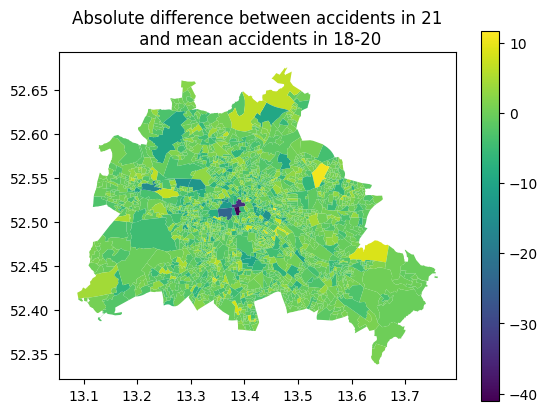

In [10]:
vote_geom['mean_accidents_18-20'] = vote_geom[['accidents_in_18', 'accidents_in_19', 'accidents_in_20']].mean(axis=1)
vote_geom['accidents_in_21_diff'] = (vote_geom['accidents_in_21']-vote_geom['mean_accidents_18-20'])
ax = vote_geom.plot(column='accidents_in_21_diff', legend=True,)
ax.set_title('Absolute difference between accidents in 21\n and mean accidents in 18-20')

Importing voting results

In [11]:
url = 'https://download.statistik-berlin-brandenburg.de/c6fffa8361dd1404/007e994c0407/DL_BE_AGHBVV2023.xlsx'
vote_results_23_Erststimme = pd.read_excel(url,sheet_name = 'AGH_W1')
vote_results_23_Zweitstimme = pd.read_excel(url,sheet_name = 'AGH_W2')
vote_results_23_Zweitstimme.head()


,Stimmart,Adresse,Bezirksnummer,Bezirksname,Wahlbezirk,Wahlbezirksart,Briefwahlbezirk,Abgeordneten-\nhauswahlkreis,Bundestags-\nwahlkreis,OstWest,...,du.,BÜNDNIS21,DIE FRAUEN,FREIE WÄHLER,Klimaliste Berlin,LD,MIETERPARTEI,Die Humanisten,Team Todenhöfer,Volt
0,Zweitstimme,01W100,1,Mitte,100,W,1A,1,75,W,...,2,2,0,0,0,0,0,1,10,12
1,Zweitstimme,01W101,1,Mitte,101,W,1B,1,75,O,...,0,0,0,0,0,0,1,0,0,10
2,Zweitstimme,01W102,1,Mitte,102,W,1B,1,75,O,...,4,0,0,2,2,0,2,1,1,1
3,Zweitstimme,01W103,1,Mitte,103,W,1C,1,75,O,...,1,0,0,0,0,0,0,0,0,12
4,Zweitstimme,01W104,1,Mitte,104,W,1D,1,75,O,...,0,0,0,1,1,0,0,1,2,19


In [12]:
#now matching vote results with geograpy

#for mail votes:
BWBs = vote_results_23_Zweitstimme.loc[vote_results_23_Zweitstimme.Wahlbezirksart=='B']['Adresse'].str[:2]+vote_results_23_Zweitstimme.loc[vote_results_23_Zweitstimme.Wahlbezirksart=='B']['Adresse'].str[3:]
vote_results_23_Zweitstimme.loc[vote_results_23_Zweitstimme.Wahlbezirksart=='B','BWB'] = BWBs
votes_per_mail =vote_geom[['BWB','geometry']].merge(vote_results_23_Zweitstimme, on='BWB', how='left')

#for normal votes
UWBs = vote_results_23_Zweitstimme.loc[vote_results_23_Zweitstimme.Wahlbezirksart=='W']['Adresse'].str[:2]+vote_results_23_Zweitstimme.loc[vote_results_23_Zweitstimme.Wahlbezirksart=='W']['Adresse'].str[3:]
vote_results_23_Zweitstimme.loc[vote_results_23_Zweitstimme.Wahlbezirksart=='W','UWB'] = UWBs
votes_in_person =vote_geom[['UWB','geometry']].merge(vote_results_23_Zweitstimme, on='UWB', how='left')


In [13]:
#next step: add up votes by post and in pesrson per geometry

In [14]:
votes_in_person[['geometry','Gültige Stimmen']]

,geometry,Gültige Stimmen
0,"POLYGON ((13.37094 52.52692, 13.36956 52.52890...",428
1,"POLYGON ((13.36896 52.53377, 13.36673 52.53577...",330
2,"POLYGON ((13.36896 52.53377, 13.36904 52.53381...",382
3,"POLYGON ((13.38218 52.53126, 13.38217 52.53127...",276
4,"POLYGON ((13.38798 52.52936, 13.38535 52.52871...",511
...,...,...
2252,"POLYGON ((13.30187 52.60840, 13.30201 52.60750...",439
2253,"POLYGON ((13.30962 52.60786, 13.30953 52.60787...",399
2254,"POLYGON ((13.29211 52.60251, 13.29362 52.60230...",540
2255,"POLYGON ((13.30120 52.60578, 13.30122 52.60573...",419


Text(0.5, 1.0, 'Percent of SPD in the Zweitstimme votes')

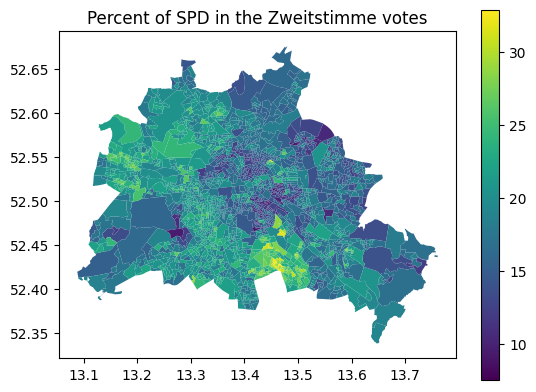

In [15]:
votes_SPD=gpd.sjoin(votes_in_person[['geometry','Gültige Stimmen','SPD']],votes_per_mail[['geometry','Gültige Stimmen','SPD']],how='left',predicate='contains')
votes_SPD['total_votes']=votes_SPD['Gültige Stimmen_left']+votes_SPD['Gültige Stimmen_right']
votes_SPD['ratio'] = 100*(votes_SPD['SPD_left']+votes_SPD['SPD_right'])/votes_SPD['total_votes']
ax=votes_SPD.plot(column='ratio', legend=True)
ax.set_title('Percent of SPD in the Zweitstimme votes')

Before switching to other topics, lets do hypothesis testing
I split the data in two goups: polygons where were more accidents in 21 in comparison with prev.3 years and not
H_0: mean SPD result is equal across two groups
H_1: mean result is not equal
alpha = 0.05

In [52]:
SPD = votes_SPD.drop(columns=['Gültige Stimmen_left','SPD_left','index_right','Gültige Stimmen_right','SPD_right','total_votes']) 
votes_vs_accidents=gpd.sjoin(SPD,vote_geom[['geometry','accidents_in_21','accidents_in_21_diff']],how='left',predicate='contains').drop(columns=['index_right'])
median=votes_vs_accidents.ratio.median()
votes_vs_accidents['more accidents']=np.where(votes_vs_accidents.accidents_in_21_diff>0,True,False)
votes_vs_accidents.value_counts('more accidents')

more accidents
False    1558
True      699
dtype: int64

In [66]:
more_accidents=votes_vs_accidents[votes_vs_accidents['more accidents']==True].ratio
less_accidents=votes_vs_accidents[votes_vs_accidents['more accidents']==False].ratio
pingouin.ttest(x=more_accidents,
y=less_accidents,
paired=False,
alternative='less')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.181774,1425.835215,less,0.014645,"[-inf, -0.09]",0.096918,1.083,0.685607


actually more accidents results in a less votes for CDU!
lets check few other hypothesises


In [69]:
gdf_accidents_19.head()

,OBJECTID,LAND,BEZ,LOR,STRASSE,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,...,UTYP1,ULICHTVERH,IstRad,IstPKW,IstFuss,IstKrad,IstGkfz,IstSonstige,USTRZUSTAND,geometry
0,49090,11,12,12301203,Wittenau Süd,2019,1,13,6,3,...,3,0,1,1,0,0,0,0.0,1,POINT (13.34146 52.58609)
1,49091,11,3,3040818,Pankow Süd,2019,1,9,5,3,...,3,0,1,1,0,0,0,0.0,0,POINT (13.41356 52.55862)
2,49093,11,12,12103115,Breitkopfbecken,2019,3,21,6,3,...,1,2,1,0,0,0,0,0.0,0,POINT (13.36034 52.57159)
3,49096,11,6,6040703,Nikolassee,2019,1,7,6,2,...,4,1,0,1,1,0,0,0.0,1,POINT (13.21777 52.42825)
4,49097,11,7,7030303,Grazer Platz,2019,2,15,3,3,...,6,0,0,1,0,0,0,0.0,0,POINT (13.36007 52.47421)


In [99]:
#here I try to get data from geoportal
from owslib.wfs import WebFeatureService
# Define the WMS endpoint URL
wms_url = "https://fbinter.stadt-berlin.de/fb/wms/senstadt/wa_SGBII_ew20"

# Define the WFS endpoint URL
wfs_url = 'https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_lor_plr_2021?request=getcapabilities&service=wfs&version=2.0.0'

# Connect to the WFS endpoint using owslib
wfs = owslib.wfs.WebFeatureService(wfs_url, version='2.0.0')

# Get the available layers from the WFS endpoint
layer_names = list(wfs.contents.keys())

# Select a layer to extract data from
layer_name = layer_names[0]

# Define the desired CRS
crs = {'init': 'epsg:4326'}

# Define the WFS request to get the data
response = wfs.getfeature(
    typename=layer_name,
    bbox=(-180, -90, 180, 90),  # Full extent of the layer
)

# Convert the response to a GeoDataFrame
#gdf = gpd.GeoDataFrame.from_features(response, crs=crs)
print(response)

In [109]:
#url='https://tsb-opendata.s3.eu-central-1.amazonaws.com/lor_planungsgraeume_2021/lor_planungsraeume_2021.geojson'

url = 'https://tsb-opendata.s3.eu-central-1.amazonaws.com/lor_planungsgraeume/lor_planungsraeume.geojson'
Berlin_LOR = gpd.read_file(url).to_crs("EPSG:4326")

print(Berlin_LOR.info())
print(Berlin_LOR.head())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BEZIRKSNAM  448 non-null    object  
 1   PLANUNGSRA  448 non-null    object  
 2   DATUM_GUEL  448 non-null    object  
 3   FLAECHENGR  448 non-null    float64 
 4   broker Dow  448 non-null    object  
 5   geometry    448 non-null    geometry
dtypes: float64(1), geometry(1), object(4)
memory usage: 21.1+ KB
None
  BEZIRKSNAM                PLANUNGSRA  DATUM_GUEL  FLAECHENGR broker Dow  \
0      Mitte              Stülerstraße  14.06.2006   366755.50   01011101   
1      Mitte         Großer Tiergarten  14.06.2006  3009397.45   01011102   
2      Mitte              Lützowstraße  14.06.2006   522356.58   01011103   
3      Mitte              Körnerstraße  14.06.2006   338383.45   01011104   
4      Mitte  Nördlicher Landwehrkanal  14.06.2006   934609.72   01011105   

                  

In [115]:
url='https://www.berlin.de/sen/gesundheit/_assets/service/daten/gesundheits-und-sozialstrukturatlas/gssa_2022_planungsraeume.csv'
GESI = pd.read_csv(url,header = 0, sep = ',',decimal=',', encoding='utf-8') 
GESI.head()

,plrID,plrNAME,GESIx_2013,GESIx_2022,ESIx_2013,ESIx_2022,DI_2013,DI_2022,DII_2013,DII_2022,DIII_2013,DIII_2022
0,1011101,Stülerstr.,.70700312,.87645614,.36569428,.37217203,.61668533,.75277644,.06563177,-.055861462,1.1962581,1.6375602
1,1011102,Großer Tiergarten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1011103,Lützowstr.,-1.4910268,-1.5584612,-.96274322,-.96761262,-.16532983,-.44076282,-1.6309689,-1.3711512,-2.2273395,-2.4057195
3,1011104,Körnerstr.,-1.7241974,-.7871176,-2.1263702,-1.2641577,-1.0487362,-.67429048,-2.9186726,-1.6929224,-.51757973,.35816917
4,1011105,Nördlicher Landwehrkanal,NaN,1.5780597,NaN,1.2484518,NaN,1.1419803,NaN,1.1958225,NaN,1.8335866


In [117]:
#now I join these two
Berlin_LOR['broker Dow']=Berlin_LOR['broker Dow'].astype(int)

Berlin_LOR=Berlin_LOR.merge(GESI, left_on='broker Dow', right_on='plrID',how='left')
Berlin_LOR.head()

,BEZIRKSNAM,PLANUNGSRA,DATUM_GUEL,FLAECHENGR,broker Dow,geometry,plrID,plrNAME,GESIx_2013,GESIx_2022,ESIx_2013,ESIx_2022,DI_2013,DI_2022,DII_2013,DII_2022,DIII_2013,DIII_2022
0,Mitte,Stülerstraße,14.06.2006,366755.50,1011101,"MULTIPOLYGON (((13.33889 52.50542, 13.33986 52...",1011101,Stülerstr.,.70700312,.87645614,.36569428,.37217203,.61668533,.75277644,.06563177,-.055861462,1.1962581,1.6375602
1,Mitte,Großer Tiergarten,14.06.2006,3009397.45,1011102,"MULTIPOLYGON (((13.33140 52.51288, 13.33141 52...",1011102,Großer Tiergarten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mitte,Lützowstraße,14.06.2006,522356.58,1011103,"MULTIPOLYGON (((13.34923 52.50307, 13.34972 52...",1011103,Lützowstr.,-1.4910268,-1.5584612,-.96274322,-.96761262,-.16532983,-.44076282,-1.6309689,-1.3711512,-2.2273395,-2.4057195
3,Mitte,Körnerstraße,14.06.2006,338383.45,1011104,"MULTIPOLYGON (((13.36254 52.49966, 13.36265 52...",1011104,Körnerstr.,-1.7241974,-.7871176,-2.1263702,-1.2641577,-1.0487362,-.67429048,-2.9186726,-1.6929224,-.51757973,.35816917
4,Mitte,Nördlicher Landwehrkanal,14.06.2006,934609.72,1011105,"MULTIPOLYGON (((13.35159 52.50976, 13.35199 52...",1011105,Nördlicher Landwehrkanal,NaN,1.5780597,NaN,1.2484518,NaN,1.1419803,NaN,1.1958225,NaN,1.8335866


Text(0.5, 1.08, 'Gesundheits- und Sozialindex (GESIx) 2022 (Datenstand: 2019)')

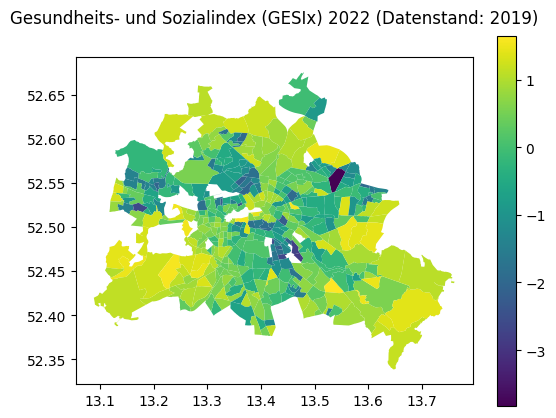

In [124]:
Berlin_LOR['GESIx_2022']=Berlin_LOR['GESIx_2022'].astype('float')
ax=Berlin_LOR.plot(column='GESIx_2022', legend=True)
ax.set_title('Gesundheits- und Sozialindex (GESIx) 2022 (Datenstand: 2019)',y=1.08)

In [179]:
#now I have to match voting districts (2k+) to LORs (~500)
Berlin_LOR.sindex.valid_query_predicates


{None,
 'contains',
 'contains_properly',
 'covered_by',
 'covers',
 'crosses',
 'intersects',
 'overlaps',
 'touches',
 'within'}

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4687 entries, 0 to 447
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   geometry     4687 non-null   geometry
 1   PLANUNGSRA   4687 non-null   object  
 2   GESIx_2022   4523 non-null   float64 
 3   index_right  4687 non-null   int64   
 4   ratio        4687 non-null   float64 
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 219.7+ KB
None


<Axes: >

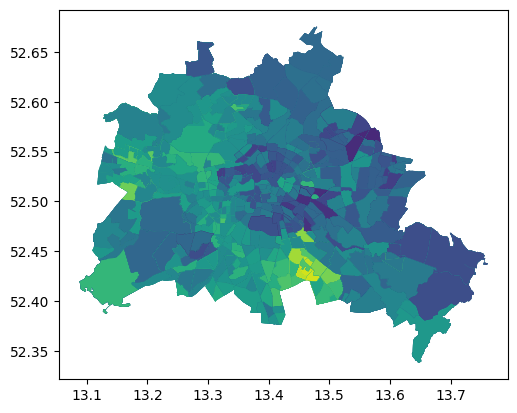

In [181]:
tmp=gpd.sjoin(Berlin_LOR[['geometry','PLANUNGSRA','GESIx_2022']],SPD,how='left',predicate='overlaps')
print(tmp.info())
tmp.plot(column='ratio')